# Semeval 2017 Task - Comparison of Different Classification Traditional and Neural Classifiers:

The purpose of this notebook is to compare the performance of traditional machine learning models using the bag-of-words text data representation with modern neural network models making use of advanced vectors space models (GloVe) and state-of-the-art transformer methods (BERT). The following models were compared:

**BoW classifiers - using count and TfIdf representations**:
1. Naive Bayes Classifier
2. Logistic Regression/Maximum Entropy Classifier
3. Linear Kernel Support Vector Classifier
4. K Nearest Neighbours Classifier

**Nerual Networks**:
1. Uni-Directional LSTM using pre-trained GloVe Embeddings
2. Bi-Directional LSTM using pre-trained GloVe Embeddings
3. Pre-trained BERT transformer

In [1]:
#Tools:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import inspect


from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tag import pos_tag
from nltk import FreqDist
from nltk import word_tokenize
import re
import pickle
import itertools
from itertools import chain
from collections import defaultdict
import time
from tqdm import trange

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics

First I load the data and evaluate the class distribution in each of the sets.

In [17]:
twitter_data_headers = ['id','sentiment','text']
twitter_train = pd.read_csv('data/twitter-training-data.txt',sep = '\t',names = twitter_data_headers)
twitter_dev = pd.read_csv('data/twitter-dev-data.txt',sep = '\t',names = twitter_data_headers)
twitter_test1 = pd.read_csv('data/twitter-test1.txt',sep = '\t',names = twitter_data_headers)
twitter_test2 = pd.read_csv('data/twitter-test2.txt',sep = '\t',names = twitter_data_headers)
twitter_test3 = pd.read_csv('data/twitter-test3.txt',sep = '\t',names = twitter_data_headers)
twitter_train['split'] = 'train'
twitter_dev['split'] = 'dev'
twitter_test1['split'] = 'test1'
twitter_test2['split'] = 'test2'
twitter_test3['split'] = 'test3'
twitter_data = twitter_train.append([twitter_dev,twitter_test1,twitter_test2,twitter_test2],ignore_index = True)

### Class distribution
Overall, neutral sentiment dominates in the training data, however the development and validation corpuses are more balanced between the positive and the neutral class. Each of the sets has the least tweets with the negative sentiment, which suggests that recognizing this class will be most difficult and also important. A good metric that should provide an overview of the classifier performance is the micro-averaged F1 Score. This metric is a harmonic mean of precision and recall, in which the contribution of each class is the same, regardless of the data imbalance:

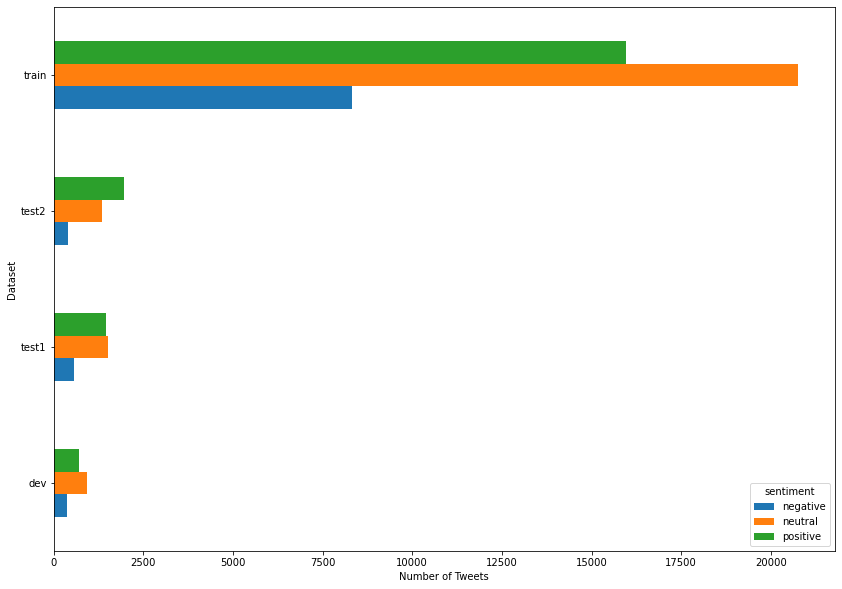

In [3]:
barchart = twitter_data.groupby("split").sentiment.value_counts().unstack().plot.barh(figsize = (14, 10))
barchart.set_xlabel('Number of Tweets')
barchart.set_ylabel('Dataset')
fig = barchart.get_figure()

## Part 1 - Bag-of-Words and Traditional Machine Learning Models

### Features 
For the bow models, it may be important to design explicit features from the data that may be indicative of a partiuclar class and will help discriminate between sentiments. Such characteristic features include emoticons, emojis, user mentions, hashstags, url and numbers in the tweets. The table below summarizes it for the training and development datasets, to evaluate whether they should simply be dropped in preprocessing or replaced with a special token:

In [4]:
def count_features(tweets):
    
    #count URls
    re_url = re.compile(r'(?:https?\:\/\/)?(?:www\.)?[a-zA-Z0-9-]+\.(?:(?:[a-zA-Z0-9-]+\.)*)?[a-z]{2,4}(?:(?:\/\S+)*)?')
    urls = [re_url.findall(x) for x in tweets]
    urls_count = [len(x) for x in urls]
    
    #remove urls
    tweets = [tweet.lower() for tweet in tweets] #lowercase
    tweets = [re.sub(r'(?:https?\:\/\/)?(?:www\.)?[a-zA-Z0-9-]+\.(?:(?:[a-zA-Z0-9-]+\.)*)?[a-z]{2,4}(?:(?:\/\S+)*)?',' ',tweet) for tweet in tweets]
    #remove extra whitespaces:
    tweets = [re.sub(r' +',' ',tweet) for tweet in tweets]
    
    #get counts of emojis and emoticons
    re_emoji = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    emojis = [re_emoji.findall(x) for x in tweets]
    emoji_count = [len(x) for x in emojis]
    
    re_emoticons_pos = re.compile(r"[oO>]?[;:=Xx8]+'?\-?[)>)pPdD3\]\}\*]+")
    emoticons_pos = [re_emoticons_pos.findall(x) for x in tweets]
    emoticon_count_pos = [len(x) for x in emoticons_pos]
    
    re_emoticons_neg = re.compile(r"[oO>]?[:;=]+'?\-?[(<\\\/\[(\{]+")
    emoticons_neg = [re_emoticons_neg.findall(x) for x in tweets]
    emoticon_count_neg = [len(x) for x in emoticons_neg]

    re_emoticons_neut = re.compile(r"[oO>]?[:;=]+'?\-?[oO]+")
    emoticons_neut = [re_emoticons_neut.findall(x) for x in tweets]
    emoticon_count_neut = [len(x) for x in emoticons_neut]
    
    #get hashtags counts
    re_hashtag = re.compile(r'\#[a-zA-Z0-9]+')
    hashtags = [re_hashtag.findall(x) for x in tweets]
    hashtag_count = [len(x) for x in hashtags]
    
    #get mention counts
    re_mention = re.compile(r'\@\w+(?!\.\w+)\b')
    mentions = [re_mention.findall(x) for x in tweets]
    mention_count = [len(x) for x in mentions]
    
    #get number counts
    re_number = re.compile(r"(\S+)?\d+(\S+)?")
    numbers = [re_number.findall(x) for x in tweets]
    number_count = [len(x) for x in numbers]
    
    
    
    return pd.DataFrame(list(zip(urls_count,emoji_count,emoticon_count_pos,
                                 emoticon_count_neg,emoticon_count_neut,hashtag_count,mention_count,number_count)),
                        columns = ['urls','emojis','emoticons-positive',
                                   'emoticons-negative','emoticons-neutral',
                                   'hashtags','mentions','numbers'])
    
    

In [5]:
test_counts = count_features(twitter_train["text"].tolist())
test_counts = test_counts.groupby(twitter_train["sentiment"]).mean().transpose()
test_counts

sentiment,negative,neutral,positive
urls,0.289167,0.409803,0.312469
emojis,0.024528,0.014844,0.038910
emoticons-positive,0.029578,0.041062,0.087719
emoticons-negative,0.022484,0.005253,0.002757
emoticons-neutral,0.001082,0.000530,0.001003
hashtags,0.364074,0.433226,0.384211
mentions,0.528796,0.427539,0.405639
numbers,0.489600,0.753145,0.672180


In [6]:
dev_counts = count_features(twitter_dev["text"].tolist())
dev_counts = dev_counts.groupby(twitter_dev["sentiment"]).mean().transpose()
dev_counts

sentiment,negative,neutral,positive
urls,0.296296,0.425462,0.330014
emojis,0.007937,0.016322,0.071124
emoticons-positive,0.023810,0.044614,0.102418
emoticons-negative,0.010582,0.008705,0.004267
emoticons-neutral,0.000000,0.002176,0.002845
hashtags,0.365079,0.499456,0.372688
mentions,0.555556,0.428727,0.421053
numbers,0.513228,0.737758,0.694168


The above analysis suggests that **positive and negative emojis** are useful features, as they correspond more ofthen with their respective class occurences. **User mentions** are expected to discriminate the negative class particularly well, therefore they will be included as explicit features too. **Numbers** also appear to be used more often by positive and neutral than negative tweets. The rest of the features will be dropped in preprocessing, as they don't seem to discriminate well between the negative amnd the positive class, which is most important in this task.

## Preprocessing for the bag-of-words model
Taking into account the above analysis, I use regualar expressions to preprocess the data, by:
1. Lowercasing the data
2. Replacing user mentions, numbers and positive/negative emoticons with special tokens.
3. Removing URLs, emojis and hashtags.
4. Removing words of length 1
5. Removing non-alphanumeric data
6. Performing **tokenizetion** using `nltk.word_tokenize`
7. Performing **stopword removal** using `nltk`'s English stopwords, with the exception of negation words, which might be useful in the bag of words bigram model.
8. Performing **lemmatization** using `nltk`'s word-net lemmatizer

In [7]:
def preprocess_bow(tweets):
    tweets = [tweet.lower() for tweet in tweets] #lowercase
    
    #remove urls
    tweets = [re.sub(r"(?:https?\:\/\/)?(?:www\.)?[a-zA-Z0-9-]+\.(?:(?:[a-zA-Z0-9-]+\.)*)?[a-z]{2,4}(?:(?:(\/|\?)\S+)*)?",' ',tweet) for tweet in tweets]

    #remove emojis
    tweets = [re.sub(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])',' ',tweet) for tweet in tweets]
    
    #replace emoticons with a token
    tweets = [re.sub(r"[oO>]?[;:=Xx8]+'?\-?[)>)pPdD3\]\}\*]+",' emoticonpos ',tweet) for tweet in tweets]
    tweets = [re.sub(r"[oO>]?[:;=]+'?\-?[(<\\\/\[)\{]+",' emoticonneg ',tweet) for tweet in tweets]
    
    #remove words of length == 1
    tweets = [re.sub(r'\b(\w)\b',' ',tweet) for tweet in tweets]
    
    #replace numbers with a token
    tweets = [re.sub(r"(\S+)?\d+(\S+)?",' numbertoken ',tweet) for tweet in tweets]
    
    #remove hashtags
    tweets = [re.sub(r'\#[a-zA-Z0-9]+',' ',tweet) for tweet in tweets]
    
    #replace user mentions with a token
    tweets = [re.sub(r'\@\w+(?!\.\w+)\b',' mentiontoken ',tweet) for tweet in tweets]
    
    #remove non alphanumeric
    tweets = [re.sub(r"\&amp"," ",tweet) for tweet in tweets] #bug in twitter - &amp appearing
    tweets = [re.sub(r"[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]+"," ",tweet) for tweet in tweets]
    #replace underscores with space
    tweets = [re.sub(r"_+"," ",tweet) for tweet in tweets]
    
    
    #remove extra whitespaces:
    tweets = [re.sub(r' +',' ',tweet) for tweet in tweets]
    
    
    #perform tokenzation:
    tweets = [word_tokenize(word) for word in tweets]
    
    #perform stopword removal - except for negation words
    stop_words = {word for word in stopwords.words('english') if not re.compile(r"\b(\w+nt|no|not)\b").match(word)}
    for i in trange(len(tweets)):
        tweets[i] = [word for word in tweets[i] if word not in stop_words]
    
    return tweets

In [8]:
train, dev, test1, test2, test3 = list(map(lambda x: preprocess_bow(x["text"].tolist()), 
                                           [twitter_train, twitter_dev, twitter_test1, twitter_test2, twitter_test3]))

100%|██████████| 2379/2379 [00:00<00:00, 292300.12it/s]


## Lemmatization:
Perform text lemmatization using WordNet lemmatizer combined with nltk's pretrained PoS tagger. In case of no tag existing for a token, treat it as a noun:

In [9]:
def wordnet_pos(tag):

    if tag.startswith('J'):
        return wordnet.ADJ #adjective
    elif tag.startswith('V'):
        return wordnet.VERB #verb
    elif tag.startswith('N'):
        return wordnet.NOUN #noun
    elif tag.startswith('R'):
        return wordnet.ADV #adverb
    else:
        return wordnet.NOUN #noun if doesn't match anything
    
def lemmatize(tweets):
    #obtain treebank tags using nltk's pretrained pos tagger
    treebank_tagged = [pos_tag(tweet) for tweet in tweets]
    
    #convert these to wordnet pos tags
    wordnet_tagged = [list(map(lambda x: (x[0], wordnet_pos(x[1])), tags)) for tags in treebank_tagged]
    
    
    #lemmatize the tweets
    lemmatizer = WordNetLemmatizer()
    tweets = [list(map(lambda x: lemmatizer.lemmatize(x[0], x[1]), tagged)) for tagged in wordnet_tagged]
    
    #join back into strings
    tweets = [" ".join(tweet) for tweet in tweets] #join back into strings
    
    return tweets

In [10]:
train, dev, test1, test2, test3 = list(map(lambda x: lemmatize(x), 
                                           [train, dev, test1, test2, test3]))

### Manual evaluation of the preprocessing results
As a sanity check, I evaluate the distribution of the preprocessed corpus, to like whether no redundant or unexpected words show up.

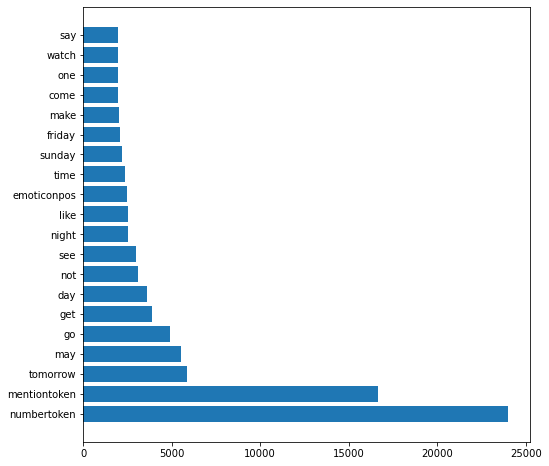

In [11]:
freq = FreqDist(list(chain.from_iterable([tweet.split() for tweet in train])))
most_common = freq.most_common(20)
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1,1,1)
ax.barh(y = [word[0] for word in most_common], width = [word[1] for word in most_common])
plt.show()

I also obtain the most popular positive words that didn't feature in most popular negative vocabulary and vice-versa, to see whether the pre-processed vocabulary discriminates well between the key classes:

In [12]:
freq_pos = FreqDist(list(chain.from_iterable([tweet.split() 
                                          for i, tweet in enumerate(train) 
                                          if twitter_train["sentiment"][i] == "positive"])))
freq_neg = FreqDist(list(chain.from_iterable([tweet.split() 
                                          for i, tweet in enumerate(train) 
                                          if twitter_train["sentiment"][i] == "negative"])))
pos_words = [word for word in freq_pos.most_common(100) if  word[0] not in [elem[0] for elem in freq_neg.most_common(100)]]
neg_words = [word for word in freq_neg.most_common(100) if  word[0] not in [elem[0] for elem in freq_pos.most_common(100)]]

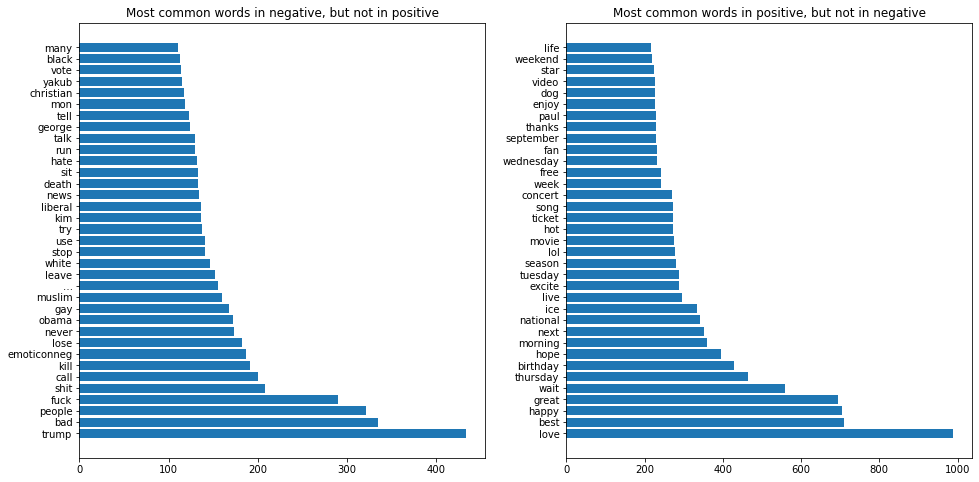

In [16]:
%matplotlib inline
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Most common words in negative, but not in positive")
ax.barh(y = [word[0] for word in neg_words], width = [word[1] for word in neg_words])
ax = fig.add_subplot(1, 2, 2)
ax.set_title("Most common words in positive, but not in negative")
ax.barh(y = [word[0] for word in pos_words], width = [word[1] for word in pos_words])
plt.savefig("figures/preprocessing.png")
plt.show()

Judging by the fact that the positive tweets include words such as "happy", "great", "best" or "love" in the top 100 and negative tweets don't, as well as that negative include words such as "fuck", "people", "bad", "trump" and the negative emoticon token, it appears that the preprocessed tokens may actually discriminate fairly well between the positive and negative classes.

## Model Training

In [11]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### Hyperparameter tuning
For each model I performed Grid Search based hyperparameter optimization. The function defined below performs grid search over a specified parameter space for both the vectorizer and the classifier, calculating accuracy and F1 score for each of the parameter combinations.

In [452]:
def grid_search_dev(Xtrain, Ytrain, Xdev, Ydev, classifier, vectorizer, param_space, return_best = False):
    """
    Run grid search with specified training and development data for 
    a defined vectorization method and classification model over a parameter space
    
    Parameters:
    Xtrain: array-like
    Ytrain: array-like
    Xdev: array-like
    Ydev: array-like
    classifier: sklearn uninitialized class
    vectorizer: sklearn.preprocessing.text vectorizer
    param_space - dictionary of parameter search space
    return_best - boolean, whether to return model with best F1
    
    Returns:
    List of dictionaries containing parameter combinations and f1 scores + accuracy
    Best fit pipe, if return_best = True
    """
    keys = param_space.keys() #all parameter names
    combs = itertools.product(*param_space.values()) #all combinations of parameters
    params = [dict(zip(keys, elem)) for elem in combs] #zip these toegether into a list of dicts
    
    for i, pars in enumerate(params): #iterate over parameter search space
        
        #get vectorizer paremeters:
        pars_vect = {k:v for k, v in pars.items() if k in inspect.getfullargspec(vectorizer).args}
        
        #get classifier parameters:
        pars_clf = {k:v for k, v in pars.items() if k in inspect.getfullargspec(classifier).args}
        
        #combine into a pipeline:
        pipe = Pipeline([("vectorizer", vectorizer(**pars_vect)), ("classifier", classifier(**pars_clf))])
        
        #fit and validate the pipeline:
        try:
            pipe.fit(Xtrain, Ytrain)
            ypred = pipe.predict(Xdev)
            params[i]["accuracy"] = accuracy_score(ypred, Ydev)
            params[i]["f1"] = f1_score(ypred, Ydev, average = "macro")
        except:
            params[i]["accuracy"] = np.nan
            params[i]["f1"] = np.nan
            
        print(f"\rEvaluated parameters {pars}, combination {i+1} out of {len(params)}", end = "")
        
    if return_best: #return best fit model
        f1 = np.array([elem["f1"] for elem in params]) #get all f1 scores
        pars = params[np.argmax(f1)] #get parameter combination with highest f1
        pars_vect = {k:v for k, v in pars.items() if k in inspect.getfullargspec(vectorizer).args}
        pars_clf = {k:v for k, v in pars.items() if k in inspect.getfullargspec(classifier).args}
        pipe = Pipeline([("vectorizer", vectorizer(**pars_vect)), ("classifier", classifier(**pars_clf))])
        pipe.fit(Xtrain, Ytrain)
        return params, pipe
        
    else:
        return params

Converting the tragets into numeric representation:

In [464]:
ylookup = {"positive": 1, "neutral": 0, "negative": -1}
ytrain, ydev, ytest1, ytest2, ytest3 = [np.array(list(map(lambda y: ylookup[y], y["sentiment"].tolist()))) for y in 
                                            [twitter_train, twitter_dev, twitter_test1, twitter_test2, twitter_test3]]

### Model 1: Naive Bayes Classifier

In [14]:
param_space = {"alpha":[1e-10, 1.0, 5.0, 10.0], 
              "fit_prior":[True, False], 
              "ngram_range":[(1,1),(1,2),(2,2)],
              "min_df":[5, 10, 50]}

#### Using Count Vectorizer:

In [15]:
res_nb_c, pipe_nb_c = grid_search_dev(train, ytrain, dev, ydev,
                      classifier = MultinomialNB, vectorizer = CountVectorizer, 
                      param_space = param_space, return_best = True)

Evaluated parameters {'alpha': 10.0, 'fit_prior': False, 'ngram_range': (2, 2), 'min_df': 50, 'accuracy': 0.404, 'f1': 0.40555477866413164}, combination 72 out of 722

In [16]:
pd.DataFrame(res_nb_c).dropna().sort_values("f1",ascending = False)[0:5]

,alpha,fit_prior,ngram_range,min_df,accuracy,f1
21,1.0,True,"(1, 2)",5,0.6115,0.609570
40,5.0,True,"(1, 2)",10,0.6150,0.607033
37,5.0,True,"(1, 1)",10,0.6165,0.606668
41,5.0,True,"(1, 2)",50,0.6125,0.605075
48,5.0,False,"(1, 2)",5,0.6095,0.604848


#### Using Tfidf Vectorizer:

In [17]:
res_nb_t, pipe_nb_t = grid_search_dev(train, ytrain, dev, ydev,
                      classifier = MultinomialNB, vectorizer = TfidfVectorizer, 
                      param_space = param_space, return_best = True)

Evaluated parameters {'alpha': 10.0, 'fit_prior': False, 'ngram_range': (2, 2), 'min_df': 50, 'accuracy': 0.414, 'f1': 0.415773087207139}, combination 72 out of 727272

In [18]:
pd.DataFrame(res_nb_t).dropna().sort_values("f1",ascending = False)[0:5]

,alpha,fit_prior,ngram_range,min_df,accuracy,f1
30,1.0,False,"(1, 2)",5,0.6020,0.600444
49,5.0,False,"(1, 2)",10,0.6055,0.596974
45,5.0,False,"(1, 1)",5,0.6090,0.594538
64,10.0,False,"(1, 1)",10,0.6075,0.591944
28,1.0,False,"(1, 1)",10,0.5925,0.591085


### Model 2: Logistic Regression

In [19]:
param_space = {"max_iter":[10000],
              "C":[10**i for i in range(-3,4)], 
              "fit_intercept":[True, False], 
              "ngram_range":[(1,1),(1,2),(2,2)],
              "min_df":[5, 10, 50]}

#### Using Count Vectorizer:

In [20]:
res_logit_c, pipe_logit_c = grid_search_dev(train, ytrain, dev, ydev,
                      classifier = MultinomialNB, vectorizer = CountVectorizer, 
                      param_space = param_space, return_best = True)

Evaluated parameters {'max_iter': 10000, 'C': 1000, 'fit_intercept': False, 'ngram_range': (2, 2), 'min_df': 50, 'accuracy': 0.519, 'f1': 0.44402973366593684}, combination 126 out of 126

In [456]:
pd.DataFrame(res_logit_c).dropna().sort_values("f1",ascending = False)[0:10]

,max_iter,C,fit_intercept,ngram_range,min_df,accuracy,f1
93,10000,100.000,True,"(1, 2)",5,0.6115,0.60957
39,10000,0.100,True,"(1, 2)",5,0.6115,0.60957
102,10000,100.000,False,"(1, 2)",5,0.6115,0.60957
84,10000,10.000,False,"(1, 2)",5,0.6115,0.60957
30,10000,0.010,False,"(1, 2)",5,0.6115,0.60957
75,10000,10.000,True,"(1, 2)",5,0.6115,0.60957
12,10000,0.001,False,"(1, 2)",5,0.6115,0.60957
111,10000,1000.000,True,"(1, 2)",5,0.6115,0.60957
120,10000,1000.000,False,"(1, 2)",5,0.6115,0.60957
66,10000,1.000,False,"(1, 2)",5,0.6115,0.60957


#### Using Tfidf Vectorizer:

In [22]:
res_logit_t, pipe_logit_t = grid_search_dev(train, ytrain, dev, ydev,
                      classifier = MultinomialNB, vectorizer = TfidfVectorizer, 
                      param_space = param_space, return_best = True)


Evaluated parameters {'max_iter': 10000, 'C': 1000, 'fit_intercept': False, 'ngram_range': (2, 2), 'min_df': 50, 'accuracy': 0.523, 'f1': 0.43148016096144914}, combination 126 out of 126

In [23]:
pd.DataFrame(res_logit_t).dropna().sort_values("f1",ascending = False)[0:10]

,max_iter,C,fit_intercept,ngram_range,min_df,accuracy,f1
31,10000,0.010,False,"(1, 2)",10,0.613,0.571136
49,10000,0.100,False,"(1, 2)",10,0.613,0.571136
94,10000,100.000,True,"(1, 2)",10,0.613,0.571136
112,10000,1000.000,True,"(1, 2)",10,0.613,0.571136
40,10000,0.100,True,"(1, 2)",10,0.613,0.571136
13,10000,0.001,False,"(1, 2)",10,0.613,0.571136
85,10000,10.000,False,"(1, 2)",10,0.613,0.571136
103,10000,100.000,False,"(1, 2)",10,0.613,0.571136
22,10000,0.010,True,"(1, 2)",10,0.613,0.571136
76,10000,10.000,True,"(1, 2)",10,0.613,0.571136


### Model 3: Support Vector Machine:

In [24]:
param_space = {"max_iter":[10000],
              "ngram_range":[(1,1),(1,2),(2,2)],
              "min_df":[5, 10],
              "C":[10**i for i in range(-2,1)],
              "penalty":["l1","l2"],
              "multi_class":["ovr","crammer"],
              "fit_itercept":[True, False],
              "class_weight":[None, "balanced"]}

#### Using Count Vectorizer:

In [25]:
res_svc_c, pipe_svc_c = grid_search_dev(train, ytrain, dev, ydev,
                      classifier = LinearSVC, vectorizer = CountVectorizer, 
                      param_space = param_space, return_best = True)

Evaluated parameters {'max_iter': 10000, 'ngram_range': (2, 2), 'min_df': 10, 'C': 1, 'penalty': 'l2', 'multi_class': 'crammer', 'fit_itercept': False, 'class_weight': 'balanced', 'accuracy': nan, 'f1': nan}, combination 288 out of 288284 out of 28888

In [26]:
pd.DataFrame(res_svc_c).dropna().sort_values("f1",ascending = False)[0:10]

,max_iter,ngram_range,min_df,C,penalty,multi_class,fit_itercept,class_weight,accuracy,f1
153,10000,"(1, 2)",10,0.01,l2,ovr,True,balanced,0.6695,0.662028
155,10000,"(1, 2)",10,0.01,l2,ovr,False,balanced,0.6695,0.662028
105,10000,"(1, 2)",5,0.01,l2,ovr,True,balanced,0.6680,0.659995
107,10000,"(1, 2)",5,0.01,l2,ovr,False,balanced,0.6680,0.659995
11,10000,"(1, 1)",5,0.01,l2,ovr,False,balanced,0.6620,0.652575
9,10000,"(1, 1)",5,0.01,l2,ovr,True,balanced,0.6620,0.652575
57,10000,"(1, 1)",10,0.01,l2,ovr,True,balanced,0.6620,0.652007
59,10000,"(1, 1)",10,0.01,l2,ovr,False,balanced,0.6620,0.652007
169,10000,"(1, 2)",10,0.10,l2,ovr,True,balanced,0.6455,0.638364
171,10000,"(1, 2)",10,0.10,l2,ovr,False,balanced,0.6455,0.638364


#### Using Tfidf Vectorizer:

In [27]:
res_svc_t, pipe_svc_t = grid_search_dev(train, ytrain, dev, ydev,
                      classifier = LinearSVC, vectorizer = TfidfVectorizer, 
                      param_space = param_space, return_best = True)

Evaluated parameters {'max_iter': 10000, 'ngram_range': (2, 2), 'min_df': 10, 'C': 1, 'penalty': 'l2', 'multi_class': 'crammer', 'fit_itercept': False, 'class_weight': 'balanced', 'accuracy': nan, 'f1': nan}, combination 288 out of 28884 out of 2882888

In [28]:
pd.DataFrame(res_svc_t).dropna().sort_values("f1",ascending = False)[0:10]

,max_iter,ngram_range,min_df,C,penalty,multi_class,fit_itercept,class_weight,accuracy,f1
169,10000,"(1, 2)",10,0.1,l2,ovr,True,balanced,0.6655,0.660108
171,10000,"(1, 2)",10,0.1,l2,ovr,False,balanced,0.6655,0.660108
123,10000,"(1, 2)",5,0.1,l2,ovr,False,balanced,0.6580,0.652416
121,10000,"(1, 2)",5,0.1,l2,ovr,True,balanced,0.6580,0.652416
73,10000,"(1, 1)",10,0.1,l2,ovr,True,balanced,0.6545,0.647857
75,10000,"(1, 1)",10,0.1,l2,ovr,False,balanced,0.6545,0.647857
27,10000,"(1, 1)",5,0.1,l2,ovr,False,balanced,0.6480,0.641912
25,10000,"(1, 1)",5,0.1,l2,ovr,True,balanced,0.6480,0.641912
187,10000,"(1, 2)",10,1.0,l2,ovr,False,balanced,0.6360,0.631038
185,10000,"(1, 2)",10,1.0,l2,ovr,True,balanced,0.6360,0.631038


### Model 4: KNN:

#### Using Count Vectorizer:

In [29]:
param_space = {"n_neighbors":[3, 5, 9],
              "weights":["uniform","distance"],
              "p":[1,2,3],
               "n_jobs":[-1],
              "ngram_range":[(1,1),(1,2),(2,2)],
              "min_df":[5, 10, 50]}

In [30]:
res_knn_c, pipe_knn_c = grid_search_dev(train, ytrain, dev, ydev,
                      classifier = KNeighborsClassifier, vectorizer = CountVectorizer, 
                      param_space = param_space, return_best = True)

Evaluated parameters {'n_neighbors': 9, 'weights': 'distance', 'p': 3, 'n_jobs': -1, 'ngram_range': (2, 2), 'min_df': 50, 'accuracy': nan, 'f1': nan}, combination 162 out of 162tion 153 out of 162

In [31]:
pd.DataFrame(res_knn_c).dropna().sort_values("f1",ascending = False)[0:10]

,n_neighbors,weights,p,n_jobs,ngram_range,min_df,accuracy,f1
96,5,distance,2,-1,"(2, 2)",5,0.4905,0.446163
69,5,uniform,2,-1,"(2, 2)",5,0.4905,0.442282
142,9,distance,1,-1,"(2, 2)",10,0.4930,0.439183
151,9,distance,2,-1,"(2, 2)",10,0.4915,0.436836
33,3,distance,1,-1,"(2, 2)",5,0.4725,0.435407
92,5,distance,2,-1,"(1, 1)",50,0.5090,0.434364
116,9,uniform,1,-1,"(2, 2)",50,0.4980,0.434326
38,3,distance,2,-1,"(1, 1)",50,0.4910,0.433873
42,3,distance,2,-1,"(2, 2)",5,0.4710,0.433472
141,9,distance,1,-1,"(2, 2)",5,0.4560,0.431850


#### Using Tfidf Vectorizer:

In [32]:
res_knn_t, pipe_knn_t = grid_search_dev(train, ytrain, dev, ydev,
                      classifier = KNeighborsClassifier, vectorizer = TfidfVectorizer, 
                      param_space = param_space, return_best = True)

Evaluated parameters {'n_neighbors': 9, 'weights': 'distance', 'p': 3, 'n_jobs': -1, 'ngram_range': (2, 2), 'min_df': 50, 'accuracy': nan, 'f1': nan}, combination 162 out of 162on 153 out of 16222

In [33]:
pd.DataFrame(res_knn_t).dropna().sort_values("f1",ascending = False)[0:10]

,n_neighbors,weights,p,n_jobs,ngram_range,min_df,accuracy,f1
88,5,distance,1,-1,"(2, 2)",10,0.5040,0.461022
38,3,distance,2,-1,"(1, 1)",50,0.4890,0.453816
115,9,uniform,1,-1,"(2, 2)",10,0.5040,0.452250
142,9,distance,1,-1,"(2, 2)",10,0.5035,0.452043
61,5,uniform,1,-1,"(2, 2)",10,0.4955,0.451365
124,9,uniform,2,-1,"(2, 2)",10,0.5075,0.450785
151,9,distance,2,-1,"(2, 2)",10,0.5060,0.450235
97,5,distance,2,-1,"(2, 2)",10,0.4930,0.443815
92,5,distance,2,-1,"(1, 1)",50,0.4975,0.438791
96,5,distance,2,-1,"(2, 2)",5,0.4640,0.438753


### Summary: Bag-of-words and traditional approaches:
To summarize the results, it appears that Support Vector Machines outperform all models in terms of both macro-averaged F1 score and accuracy. What is more suprising is that the Tfidf transformation of the bag-of-words feature matrix does not offer much improvement in performance of either model in comparison to the similer count vectorization. In fact, some models, such as Logistic Regression or Naive Bayes classifier seem to outperform their Tfidf-based counterparts when using count vectorization. This paradoxical finding might result from the fact that more frequent tokens in the corpus carry more predictive power (i.e. sentimental meaning) than rare ones - Tfidf scores for such tokens are likely to be close to 0, which would limit their impact on the model's decision boundaries. This makes intuitive sense, as words we use to express our emotions are likely to be more frequent and come from a vocabularity set with relatively low cardiality, as compared to multitude of descriptive tokens with limited valence. The table below provides summaries of the re-fitted modes on three previously unseen datasets.

In [502]:
res = defaultdict(lambda: dict())
for i, (data, target) in enumerate(zip([test1, test2, test3], [ytest1, ytest2, ytest3])):
    for j, model in enumerate([pipe_nb_c, pipe_logit_c, pipe_svc_c, pipe_knn_t]):
        ypred = model.predict(data)
        res[models[j]]["test" + str(i + 1)] = f1_score(ypred, target, average = "macro") 
pd.DataFrame(dict(res))

,NaiveBayes-Count,MaxEnt-Count,SVC-Count,KNN-Tfidf
test1,0.571585,0.554163,0.630536,0.387227
test2,0.568195,0.575681,0.622686,0.381052
test3,0.554254,0.544365,0.590027,0.379937


In [572]:
pd.DataFrame(dict(res)).to_markdown()

'|       |   NaiveBayes-Count |   MaxEnt-Count |   SVC-Count |   KNN-Tfidf |\n|:------|-------------------:|---------------:|------------:|------------:|\n| test1 |           0.571585 |       0.554163 |    0.630536 |    0.387227 |\n| test2 |           0.568195 |       0.575681 |    0.622686 |    0.381052 |\n| test3 |           0.554254 |       0.544365 |    0.590027 |    0.379937 |'

## Part 2 - Neural Networks
The superiority of neural network models in Natural Language Processing has been recognized for a while. The second part of the project evaluated whether such models outperform traditional ML approaches on the 2017 sentiment evaluation task with a relatively small number of training examples. 

#### GloVe and LSTM networks - Preprocessing

In [34]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


The preprocessing in this case is slightly different. The data is represented as integer sequences and then matched with the appropriate GloVe embedding vectors. The GloVe vectors were obtained from the pre-trained embeddings database shared by the Stanford University, available here https://nlp.stanford.edu/projects/glove/. Due to high dimensionality of the data, only the top fraction of the most popular tokens are used in the task.  Furthermore, special tokens (emoticons, etc) are not used in the task, as they don't have a matching glove vector representation. et sequence length to max length of training tweet and maximum words to be used to 5000:

First, obtain one-hot encoded targets:

In [42]:
ytrain, ydev, ytest1, ytest2, ytest3 = [pd.get_dummies(target).values for target in 
                                        [ytrain, ydev, ytest1, ytest2, ytest3]]

Run preprocessing:

In [54]:
def preprocess_lstm(tweets):
    tweets = [tweet.lower() for tweet in tweets] #lowercase
    
    #remove urls
    tweets = [re.sub(r"(?:https?\:\/\/)?(?:www\.)?[a-zA-Z0-9-]+\.(?:(?:[a-zA-Z0-9-]+\.)*)?[a-z]{2,4}(?:(?:(\/|\?)\S+)*)?",' ',tweet) for tweet in tweets]

    #remove emojis and emoticons
    tweets = [re.sub(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])',' ',tweet) for tweet in tweets]
    tweets = [re.sub(r"[oO>]?[;:=Xx8]+'?\-?[)>)pPdD3\]\}\*]+",' ',tweet) for tweet in tweets]
    tweets = [re.sub(r"[oO>]?[:;=]+'?\-?[(<\\\/\[)\{]+",' ',tweet) for tweet in tweets]
    
    #remove words of length == 1
    tweets = [re.sub(r'\b(\w)\b',' ',tweet) for tweet in tweets]
    
    #remove numbers
    tweets = [re.sub(r"(\S+)?\d+(\S+)?",' ',tweet) for tweet in tweets]
    
    #remove hashtags
    tweets = [re.sub(r'\#[a-zA-Z0-9]+',' ',tweet) for tweet in tweets]
    
    #remove user mentions
    tweets = [re.sub(r'\@\w+(?!\.\w+)\b',' ',tweet) for tweet in tweets]
    
    #remove non alphanumeric
    tweets = [re.sub(r"\&amp"," ",tweet) for tweet in tweets] #bug in twitter - &amp appearing
    tweets = [re.sub(r"[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~]+"," ",tweet) for tweet in tweets]
    
    #replace underscores with space
    tweets = [re.sub(r"_+"," ",tweet) for tweet in tweets]
    
    
    #remove extra whitespaces:
    tweets = [re.sub(r' +',' ',tweet) for tweet in tweets]
    
    
    #perform tokenzation:
    tweets = [word_tokenize(word) for word in tweets]
    
    #perform stopword removal - except for negation words
    stop_words = {word for word in stopwords.words('english') if not re.compile(r"\b(\w+nt|no|not)\b").match(word)}
    for i in trange(len(tweets)):
        tweets[i] = [word for word in tweets[i] if word not in stop_words]
        
    tweets = lemmatize(tweets)
    
    
    return tweets

In [252]:
seq_length = 30 #could consider longer sequences
max_words = 10000 #number of words to be used in the model
train, dev, test1, test2, test3 = list(map(lambda x: preprocess_lstm(x["text"].tolist()), 
                                           [twitter_train, twitter_dev, twitter_test1, twitter_test2, twitter_test3]))

100%|██████████| 2379/2379 [00:00<00:00, 350175.44it/s]


In [253]:
#init tokenizer and fit on training data:
twitter_tokenizer = Tokenizer(num_words = max_words, split = ' ',filters = ' ')
twitter_tokenizer.fit_on_texts(train)

#define tokenization function
def tokenize(tweets, tokenizer, seq_len):
    #tokenize 
    tweets = tokenizer.texts_to_sequences(tweets)
    #pad with 0s
    tweets = pad_sequences(tweets, seq_len)
    return tweets

#run on datasets
train, dev, test1, test2, test3 = [tokenize(data, twitter_tokenizer, seq_length) for data in 
                                   [train, dev, test1, test2, test3]]

Load pre-trained GloVe embeddings:

In [239]:
emb_mat = np.zeros((max_words, 100))
with open("/home/piotr/nlp/glove.6B.100d.txt",encoding = "utf-8") as f:
    for line in f:
        elements = line.split()
        if elements[0] in twitter_tokenizer.word_index and twitter_tokenizer.word_index[elements[0]] <= max_words:
            emb_mat[twitter_tokenizer.word_index[elements[0]] - 1] = elements[1:]
print(np.sum(emb_mat.any(axis = 1)))

9716


Import Pytorch utilities and define helper functions to convert between numpy arrays and torch tensors:

In [290]:
#import NN
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm 
from torch.nn import functional as F



#pass to appropriate device
USE_CUDA = torch.cuda.is_available() 
def cuda(v):
    if USE_CUDA:
        return v.cuda()
    return v

#convert numpy to tensor
def toTensor(v,dtype = torch.float,requires_grad = False):       
    return cuda(Variable(torch.tensor(v)).type(dtype).requires_grad_(requires_grad))

#convert tensor to numpy
def toNumpy(v):
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

#convert to torch dataset
def toTorchData(X, Y):
    x = toTensor(X, dtype = torch.long)
    y = toTensor(Y)
    dataset = torch.utils.data.TensorDataset(x, y)
    return dataset

Convert everything into pytorch tensors & datasets:

In [260]:
train, dev, test1, test2, test3 = [toTorchData(x, y) for x, y in 
 zip([train, dev, test1, test2, test3],
     [ytrain, ydev, ytest1, ytest2, ytest3])]
emb_mat = toTensor(emb_mat)

/home/piotr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Define the network architecture:

In [443]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(emb_mat)
        #LSTM - 50 units of hidden size
        self.lstm = nn.LSTM(input_size = 100, hidden_size = 128, batch_first = True)
        #batch normalization - regularize:
        self.norm = nn.BatchNorm1d(128)
        #linear classifier
        self.clf = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(), 
            nn.Linear(128, 3))
        
    def forward(self, x):
        out = self.embedding(x)
        _, (out, _) = self.lstm(out)
        out = self.norm(out)
        out = self.clf(out)
        out = F.softmax(out.view(-1, 3), dim = 1)
        return out

Below I train the network with specified number of epochs, batch size and learning rate. 

In [431]:
num_epochs = 20
batch_size = 128
learning_rate = 0.001
model = cuda(Net())

#loader for training
train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=True)
#loader for testing

dev_loader = torch.utils.data.DataLoader(dataset=dev, 
                                          batch_size=batch_size, #do one batch for now
                                          shuffle=False)


# Loss and Optimizer
criterion = nn.MultiLabelSoftMarginLoss()  #Cross Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#history.append({"train":[],"validation":[], "predictions":[]}) #track values for each cv-fold
history = {"train":[], "validation":[]}

for epoch in tqdm(range(num_epochs)):
        
        #training
        model.train()
        train_loss = []
        for inputs, labels in train_loader:  #pick a batch
            # Pass to cuda
            inputs = cuda(inputs)
            labels = cuda(labels)

            
            outputs = model(inputs) #forward pass
            loss = criterion(outputs, labels) #loss
            optimizer.zero_grad()  # zero the gradient buffer
            loss.backward() #backward pass
            optimizer.step() #optimization
            train_loss.append(toNumpy(loss)) #save loss
            torch.cuda.empty_cache()
            print("\rEpoch {} Mean training loss {}".format(epoch, np.mean(train_loss)), end = "")
        history["train"].append(np.mean(train_loss))
            
            
        #evaluation
        model.eval()
        validation_loss = []
        for inputs, labels in dev_loader:
            # Pass to cuda
            inputs = cuda(inputs)
            labels = cuda(labels)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss.append(toNumpy(loss)) #save loss
            torch.cuda.empty_cache()
            print("\rEpoch {} Mean validation loss {}".format(epoch, np.mean(validation_loss)), end = "")
        history["validation"].append(np.mean(validation_loss))
            

Epoch 39 Mean validation loss 0.7135560512542725


<IPython.core.display.Javascript object>


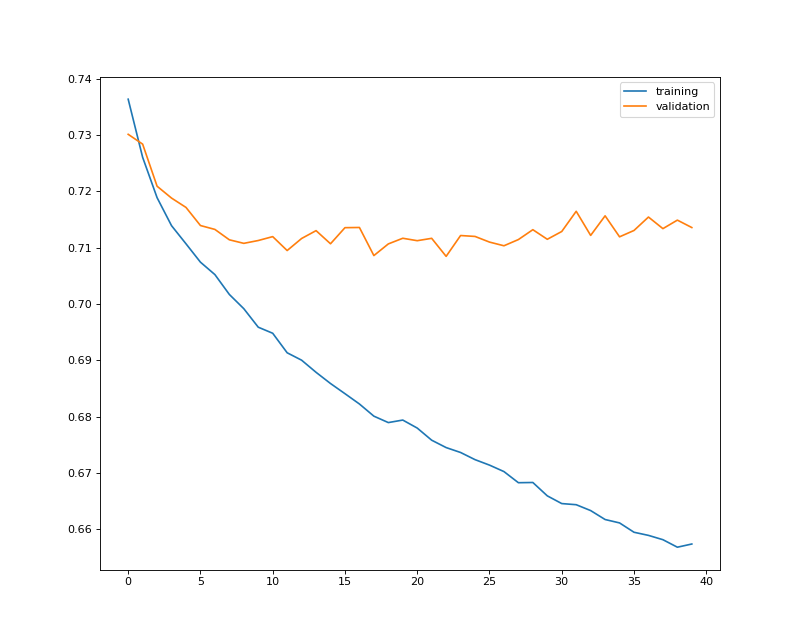

In [441]:
%matplotlib notebook
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(history["train"])
ax.plot(history["validation"])
ax.legend(["training","validation"])
plt.show()

### Network evaluation
I defined a function to create and write clear-cut evaluation summaries as Python dictionaries, serialize them intro json strings and write them to a text file. This allows me to keep track of the subsequent training results and corresponding hyperparameter combinations to ensure that I'm moving in the right direction while optimizing them. 

In [419]:
def evaluate_network(x, y, model, optimizer, num_epochs, file = None):
    """
    Evaluate network results using pairwise F1 scores and Accuracy. 
    Write results to file if specified.
    x: torch.Tensor
        test data
    y: np.array
        one-hot encoded targets
    model: torch.nn.Module
        fitted network
    file: str
        filename to save parameters
    """
    model.eval()
    ypred = model(x).detach().numpy().argmax(axis = 1)
    ytrue = y.argmax(axis = 1)
    
    
    results = dict()
    
    #get params:
    for name, param in model.named_parameters():
        results[name] = param.shape[0]
    
    #add optimizer parameters
    results.update(optimizer.defaults)
    
    #add num epochs
    results["num_epochs"] = num_epochs
    
    #get overall and pairwise F1:
    results["f1_overall"] = f1_score(ytrue, ypred, average = "macro")
    results["f1_neg_vs_neu"] = f1_score(ytrue, ypred, average = "macro", labels = [0,1])
    results["f1_neu_vs_pos"] = f1_score(ytrue, ypred, average = "macro", labels = [1,2])
    results["f1_neg_vs_pos"] = f1_score(ytrue, ypred, average = "macro", labels = [0,2])
    #get accuracy:
    results["acc"] = accuracy_score(ytrue, ypred)
    
    #convert to string to make it json-serializable
    results = {k:str(v) for k, v in results.items()}
    
    if file and os.path.isfile(file):
        with open(file, "a") as f:
            line = json.dumps(results)
            f.write(line + "\n")
    elif file and not os.path.isfile(file):
        with open(file, "w") as f:
            line = json.dumps(results)
            f.write(line + "\n")
            
    return results

In [439]:
evaluate_network(dev.tensors[0], ydev, model, optimizer, num_epochs, file = "lstm_results.txt")

{'embedding.weight': '10000',
 'lstm.weight_ih_l0': '512',
 'lstm.weight_hh_l0': '512',
 'lstm.bias_ih_l0': '512',
 'lstm.bias_hh_l0': '512',
 'clf.0.weight': '128',
 'clf.0.bias': '128',
 'clf.2.weight': '3',
 'clf.2.bias': '3',
 'lr': '0.001',
 'betas': '(0.9, 0.999)',
 'eps': '1e-08',
 'weight_decay': '0',
 'amsgrad': 'False',
 'num_epochs': '40',
 'f1_overall': '0.44402304240641427',
 'f1_neg_vs_neu': '0.3796604296604297',
 'f1_neu_vs_pos': '0.6057435033185611',
 'f1_neg_vs_pos': '0.346665194240252',
 'acc': '0.555'}

### BERT Transformer
*Coming soon!*